Предыдущий этап в step_1_parser - парсер и первичный анализ

## ЭТАП 2

Гипотеза на основании предыдущего этапа - есть ряд регулярных новостей, в момент выхода которых заметно увеличивается волатильность рынка. Цель второго этапа исследования:

* выявить "сильные" новостные показатели, проверить гипотезу об увеличенном их влиянии на волатильность,
* построить модель прогнозирования волатильности с использованием информации о выходе новостных показателей.

### 1. Выбор оцениваемых параметров и формирование датасета

Волатильность будем оценивать в абсолютных и относительных показателях.

При этом, если в первичном анализе использовалась группировка котировок и новостей по дням, то на данном этапе исследуем данные и влияние новостных показателей более детально на таймфрейме 15 минут (M15). Т.е. будет оцениваться влияние новости на 15 минтутных интервалах, в которые новость вышла.

Для относительной оценки будет расчитана дневная волатильность (D1) и вычислено отношение волатильности M15 к D1.

In [1]:
import time
import pandas as pd
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [121]:
news = pd.read_csv('input/calendar-event-list.csv')
news['datetime'] = pd.to_datetime(news['Start'])
news = news.drop(columns=['Start', 'Id'])
news.columns = ['title', 'impact', 'currency', 'datetime']
news = news[(news.currency=='EUR') | (news.currency=='USD')]
news = news.set_index('datetime')
# отбираем сильные и средние новости, которые при этом регулярные - выходят не менее 5 раз в год
reg_news = news[(news['impact'] == 'MEDIUM') | (news['impact'] == 'HIGH')].\
    groupby('title').filter(lambda x: len(x) >= 5)[['title', 'impact']]
reg_news.head()

,title,impact
datetime,,
2020-01-02 08:55:00,Markit Manufacturing PMI,MEDIUM
2020-01-02 13:30:00,Initial Jobless Claims,MEDIUM
2020-01-02 13:30:00,Initial Jobless Claims 4-week average,MEDIUM
2020-01-02 14:45:00,Markit Manufacturing PMI,MEDIUM
2020-01-03 08:55:00,Unemployment Change,MEDIUM


In [124]:
reg_news_m15 = pd.get_dummies(reg_news.title).resample('15min').sum()

In [125]:
%%time

#работа с котировками

# источник
quotes_src = pd.read_csv('input/eurusd_m1.csv')
quotes_src['date'] = pd.to_datetime(quotes_src['Gmt time'], format='%d.%m.%Y %H:%M:%S.000')
quotes_src = quotes_src.drop(columns=['Gmt time', 'Volume'])
# m1 с индексом датой
m1_quotes = quotes_src.set_index('date')

# группируем минутки в данные m15 и добавляем волатильность 
ohlc_dict = {'Open':'first', 'High':'max', 'Low':'min', 'Close': 'last'}
m15_quotes = m1_quotes.resample('15min').apply(ohlc_dict)
m15_quotes = m15_quotes[m15_quotes.index.weekday < 5] # удаляем СБ и ВСК с нулевой волатильностью по итогам 1 этапа
# волатильность - амплитуду движения за день - считаем в пунктах по 5-му знаку,
# умножая для этого на 10^5
m15_quotes['volatility'] = (abs(m15_quotes.High - m15_quotes.Low) * 10**5).astype(int)

# добавление относительной волатильности (m15/d1)
# отдельно группируем минутки в данные d1 и получаем дневную волатильность для дальнейшего расчета относительной
d1_quotes = m1_quotes.resample('D').apply(ohlc_dict)
d1_quotes = d1_quotes[d1_quotes.index.weekday < 5] # удаляем СБ и ВСК с нулевой волатильностью по итогам 1 этапа
d1_quotes['volatility_d1'] = (abs(d1_quotes.High - d1_quotes.Low) * 10**5).astype(int)
d1_quotes = d1_quotes[['volatility_d1']]
# добавляем для m15 относительную волатильность по отношению к дневной
m15_quotes = m15_quotes.join(d1_quotes[['volatility_d1']])
m15_quotes['volatility_d1'] = m15_quotes['volatility_d1'].fillna(method='ffill')
m15_quotes['vol_relative'] = round(m15_quotes['volatility'] / m15_quotes['volatility_d1'], 5)
#m15_quotes = m15_quotes.drop(['volatility_d1'], axis=1)
m15_quotes[100:].head()

Wall time: 1.8 s


,Open,High,Low,Close,volatility,volatility_d1,vol_relative
date,,,,,,,
2020-01-02 01:00:00,1.12182,1.12231,1.12180,1.12225,51,609.0,0.08374
2020-01-02 01:15:00,1.12225,1.12244,1.12219,1.12236,24,609.0,0.03941
2020-01-02 01:30:00,1.12234,1.12237,1.12210,1.12210,26,609.0,0.04269
2020-01-02 01:45:00,1.12210,1.12211,1.12180,1.12209,31,609.0,0.05090
2020-01-02 02:00:00,1.12210,1.12210,1.12184,1.12190,26,609.0,0.04269


In [127]:
# формируем разреженную таблицу новостей
sparse_news = m15_quotes.join(reg_news_m15).fillna(0)
# приводим к целочисленному типу ячейки новостей
sparse_news = sparse_news.iloc[:, :7].join(sparse_news.iloc[:, 7:].astype('int'))
# формирование колонки, где 1 - отсутствие новостей (для сравнения в будущем)
sparse_news['no_news'] = (sparse_news.iloc[:, 7:].sum(axis=1) == 0) * 1

### 2. Предварительные оценки разброса абсолютной и относительной волатильности в зависимости от новости

In [130]:
# список всех используемых новостей
news_list = sparse_news.columns[7:]
# формируем разреженную таблицу новостей со значениями относительной волительности
sparse_news_rel = m15_quotes.join(reg_news_m15) # это, если надо наны оставить
# sparse_news_rel = sparse_news # заменить на это, если нужны 0 вместо нанов
# формирование колонки, где 1 - отсутствие новостей (для сравнения в будущем)
sparse_news_rel['no_news'] = ((sparse_news_rel.iloc[:, 7:].sum(axis=1) > 0.0) == False) * 1

for news in news_list:
    sparse_news_rel[news] = sparse_news_rel['vol_relative'] * sparse_news_rel[news]

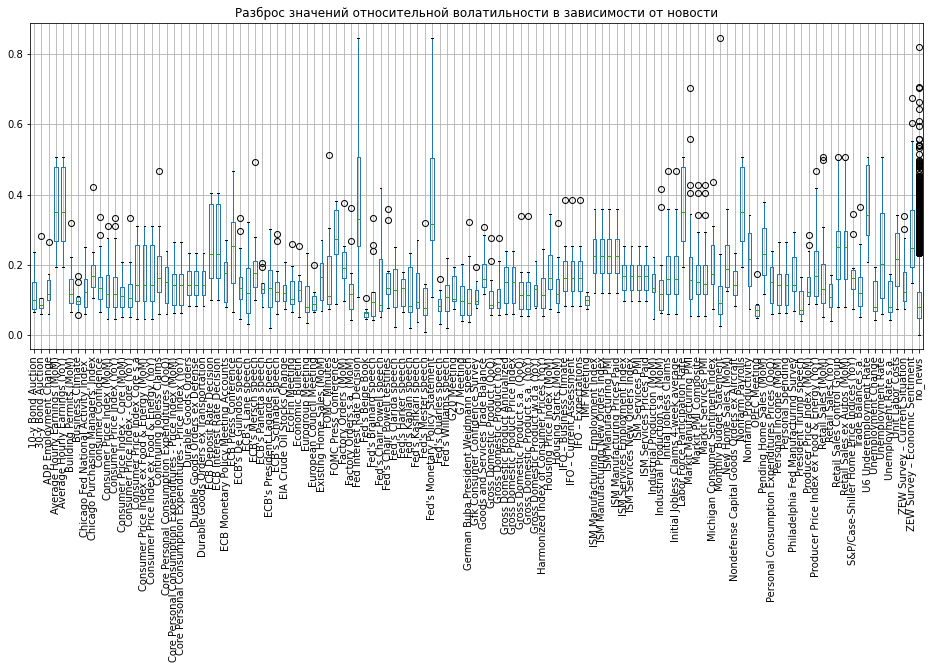

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

sparse_news_rel.iloc[:, 7:].mask(sparse_news_rel==0).boxplot()

plt.title('Разброс значений относительной волатильности в зависимости от новости')
plt.xticks(rotation = 90)
plt.show()

In [131]:
# формируем разреженную таблицу новостей с абсолютными значениями волатильности
sparse_news_vol = m15_quotes.join(reg_news_m15) # это, если надо наны оставить
# sparse_news_vol = sparse_news # заменить на это, если нужны 0 вместо нанов
# формирование колонки, где 1 - отсутствие новостей (для сравнения в будущем)
sparse_news_vol['no_news'] = ((sparse_news_vol.iloc[:, 7:].sum(axis=1) > 0.0) == False) * 1

for news in news_list:
    sparse_news_vol[news] = sparse_news_vol['volatility'] * sparse_news_vol[news]

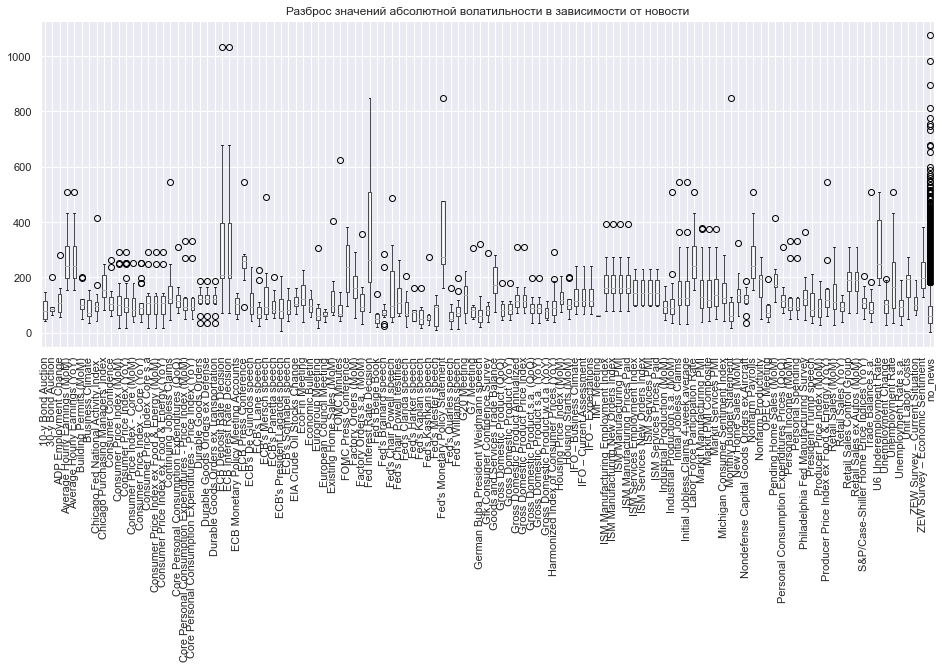

In [132]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

sparse_news_vol.iloc[:, 7:].mask(sparse_news_vol==0).boxplot()

plt.title('Разброс значений абсолютной волатильности в зависимости от новости')
plt.xticks(rotation = 90)
plt.show()

Видно, что некоторые новости явно выделяются, как по относительной, так и по абсолютной оценкам. Построим сводную таблицу сравнения эффекта новостей и отобразим ТОП-20 новостей.

In [135]:
# построим сравнительную таблицу волатильности для новостей
pivot_news_vol = pd.DataFrame(news_list, columns=['news'])
pivot_news_vol['volatility'] = ''
pivot_news_vol['volatility_d1'] = ''
pivot_news_vol['vol_relative'] = ''
pivot_news_vol['cnt'] = ''
pivot_news_vol = pivot_news_vol.set_index('news')

# формирование списка новостей с расчитанными средними показаниями волатильности
for item in news_list:
    try:
        pivot_news_vol.loc[item] = sparse_news.pivot_table(index=[item], values=['volatility', 'volatility_d1', 'vol_relative'], aggfunc=['mean'])['mean'].loc[1]
    except:
        pivot_news_vol.loc[item] = sparse_news.pivot_table(index=[item], values=['volatility', 'volatility_d1', 'vol_relative'], aggfunc=['mean'])['mean'].iloc[1]
    pivot_news_vol['cnt'].loc[item] = sparse_news[item].sum()

pivot_news_vol = pivot_news_vol.sort_values(by='volatility', ascending=False)
pivot_news_vol.head(20)

,volatility,volatility_d1,vol_relative,cnt
news,,,,
Fed's Monetary Policy Statement,401.8,1046.8,0.408206,5
ECB Interest Rate Decision,361.875,1294.12,0.254244,8
ECB Deposit Rate Decision,361.875,1294.12,0.254244,8
Fed Interest Rate Decision,360,914.5,0.388671,8
U6 Underemployment Rate,298,833.444,0.362433,9
Average Hourly Earnings (MoM),277.167,817.083,0.357688,12
Average Hourly Earnings (YoY),277.167,817.083,0.357688,12
Nonfarm Payrolls,277.167,817.083,0.357688,12
Labor Force Participation Rate,277.167,817.083,0.357688,12


Посмотрим на сравнение в графическом виде

<AxesSubplot:title={'center':'Средняя волатильность d1 и m15 в зависимости от новости'}, xlabel='news'>

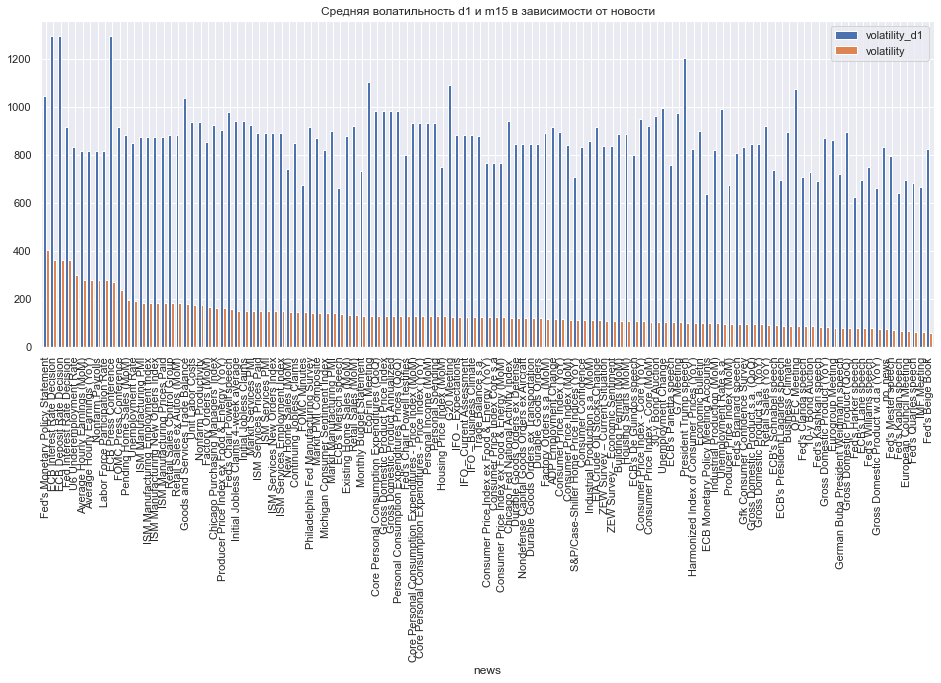

In [136]:
pivot_news_vol[['volatility_d1', 'volatility']].plot(kind='bar', figsize=(16, 6), width=0.8,\
     title='Средняя волатильность d1 и m15 в зависимости от новости')

Отберем топ 20, чтобы посмотреть поближе на самые сильные новостные показатели

<AxesSubplot:title={'center':'Средняя волатильность d1 и m15 в зависимости от новости'}, xlabel='news'>

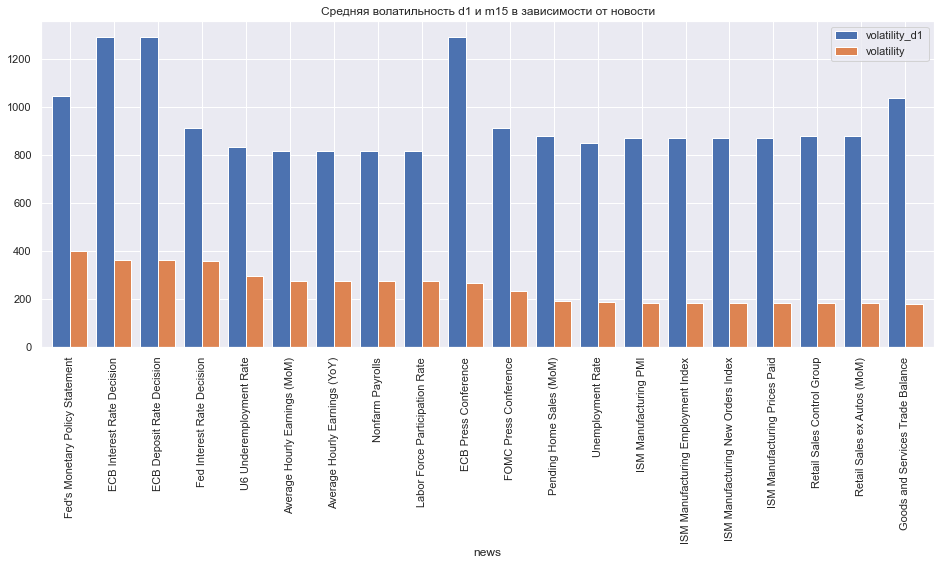

In [138]:
pivot_news_vol[['volatility_d1', 'volatility']].head(20).plot(kind='bar', figsize=(16, 6), width=0.8,\
     title='Средняя волатильность d1 и m15 в зависимости от новости')

Интересно, что в топ попали MEDIUM новости, которые опередили некоторые HIGH. К таким относится, например, Labor Force Participation Rate.

Посмотрим на хвост - наиболее слабые из новостей списка HIGH-MEDIUM

<AxesSubplot:title={'center':'Хвост графика средней волатильности - см. no_news'}, xlabel='news'>

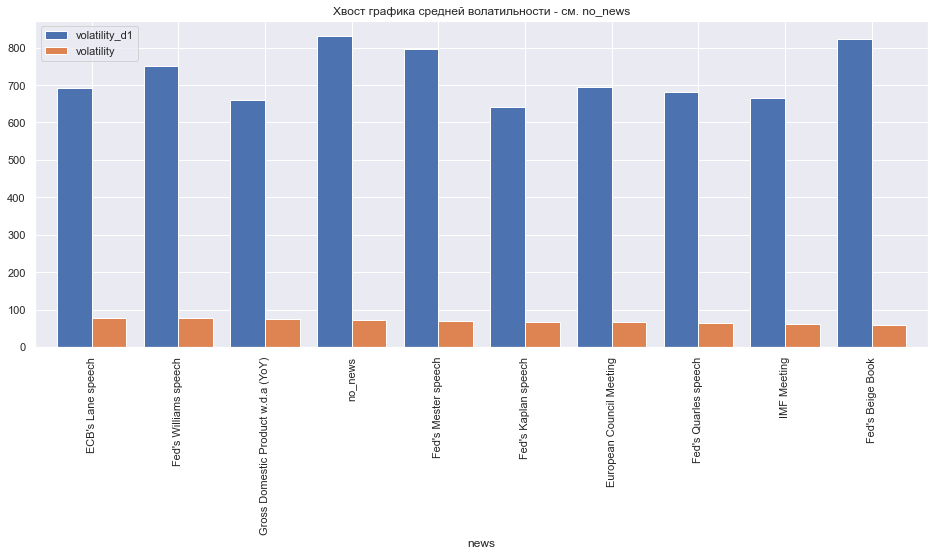

In [139]:
pivot_news_vol[['volatility_d1', 'volatility']].tail(10).plot(kind='bar', figsize=(16, 6), width=0.8,\
     title='Хвост графика средней волатильности - см. no_news')

Можно заметить, что интервал без новостей (no_news) по волатильности тоже находится в хвосте, что ожидаемо 

### 3. Проверка гипотезы

Свободная формулировка: В интервал М15, в которую выходит топ-20 новостей, волатильность составляет не менее 20% от волатильности дня.

Формулируем одностороннюю гипотезу.

* H0 - средняя относительная волатильность (vol_relative) во время интервала М15 выхода топ-20 новости равно или меньше 20% от волатильности дня.
* H1 - альтернативная гипотеза: волатильность в М15 выхода новости больше 20%

In [18]:
# отберем топ-20 новостей
top_news = pivot_news_vol.head(20).index
# отбираем те дни, в которые встречаются топ новости
top_sparse_news = sparse_news[['vol_relative', *top_news]]
top_sparse_news = top_sparse_news.loc[~(top_sparse_news.iloc[:, 1:]==0).all(axis=1)]

In [19]:
from scipy import stats as st

interested_value = .2
alpha = .005

results = st.ttest_1samp(top_sparse_news['vol_relative'], interested_value)
mean = top_sparse_news['vol_relative'].mean()
pvalue = results.pvalue/2 # тест односторонний: p-value будет в 2 раза меньше

print('Средняя волатильность:', mean)
print('p-value:', pvalue)

# тест односторонний вправо:
# отвергаем гипотезу только в случае, если выборочное среднее значимо больше предполагаемого значения
if (pvalue < alpha) and (mean > interested_value):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средняя волатильность: 0.2501848484848485
p-value: 0.0001739557473348027
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута в пользу альтернативной. Выборочное среднее значимо больше предполагаемого значения. Следовательно средняя волатильность в момент выхода топ-новости (в интервале 15 минут) действительно может превышать 20% от дневной волатильности

### 4. Модель
#### 4.1 Подготовка данных

Будем предсказывать волатильность часа. Используем в т.ч. полученные данные о влиянии новостей. Посмотрим на целевую переменную

Рэсемплим минутки в часовики

In [20]:
# группируем минутки в данные h1 и добавляем волатильность 
ohlc_dict = {'Open':'first', 'High':'max', 'Low':'min', 'Close': 'last'}
h1_quotes = m1_quotes.resample('H').apply(ohlc_dict)
h1_quotes = h1_quotes[h1_quotes.index.weekday < 5] # удаляем СБ и ВСК с нулевой волатильностью по итогам 1 этапа
# волатильность - амплитуду движения за день - считаем в пунктах по 5-му знаку,
# умножая для этого на 10^5
h1_quotes['volatility'] = (abs(h1_quotes.High - h1_quotes.Low) * 10**5).astype(int)
h1_quotes = h1_quotes.drop(['Open', 'High', 'Low', 'Close'], axis=1)
h1_quotes[100:].head()

,volatility
date,
2020-01-07 04:00:00,28
2020-01-07 05:00:00,96
2020-01-07 06:00:00,87
2020-01-07 07:00:00,124
2020-01-07 08:00:00,148


Целевая переменная - volatility. Посмотрим на ее распределение

<AxesSubplot:>

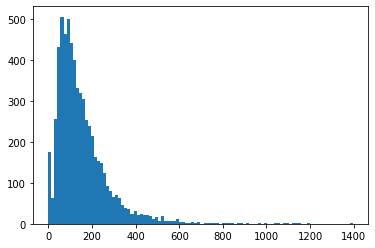

In [21]:
h1_quotes.volatility.hist(bins=100, grid=False)

На графике можно заметить распределение, близкое к нормальному, но смещенное. С правым хвостом

Посмотрим, как выглядит распределение волатильности по дням

<AxesSubplot:xlabel='date'>

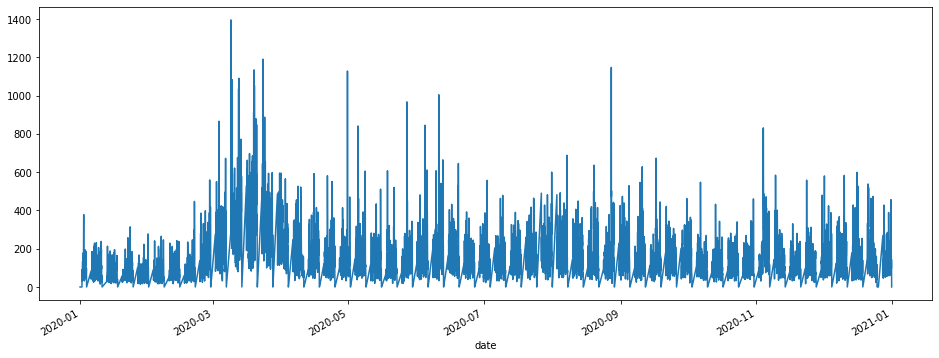

In [22]:
h1_quotes.volatility.plot(figsize=(16, 6))

Видна периодичность. Скорее всего недельня, когда волатильность становится нулевой. Хотя выходные дни удалены, но последние часы пятницы из-за раннего закрытия тоже могут оказаться нулевыми

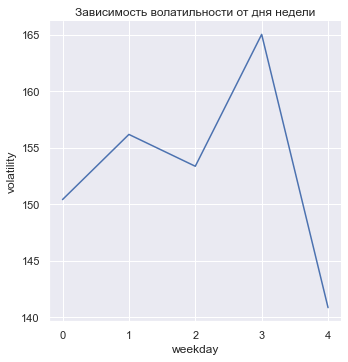

In [23]:
#h1_quotes = h1_quotes.reset_index()
h1_quotes['weekday'] = h1_quotes.index.weekday
dur_by_weekday = h1_quotes.groupby('weekday')
sns.set(font_scale=1)
sns.relplot(data=dur_by_weekday.volatility.aggregate('mean'), kind='line').\
    set(title='Зависимость волатильности от дня недели');

Посмотрим на зависимость от часов + день недели

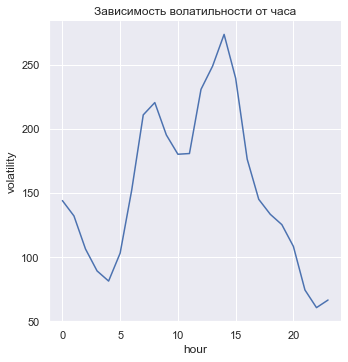

In [24]:
h1_quotes['hour'] = h1_quotes.index.hour
# волатильность от часа в сутках
dur_by_hour= h1_quotes.groupby('hour')
sns.set(font_scale=1)
sns.relplot(data=dur_by_hour.volatility.aggregate('mean'), kind='line').\
    set(title='Зависимость волатильности от часа');

Днем волатильность гораздо выше, что связано в т.ч. с выходом новостей. Добавим новости и подготовтим датасет, закодировав признаки

In [140]:
# отбираем все доступные новости
reg_news_all = pd.read_csv('input/calendar-event-list.csv')
reg_news_all['datetime'] = pd.to_datetime(reg_news_all['Start'])
reg_news_all = reg_news_all.drop(columns=['Start', 'Id'])
reg_news_all.columns = ['title', 'impact', 'currency', 'datetime']
reg_news_all = reg_news_all[(reg_news_all.currency=='EUR') | (reg_news_all.currency=='USD')]
reg_news_all = reg_news_all.set_index('datetime')

# кодируем признаки
reg_news_h1 = pd.get_dummies(data=reg_news_all, columns=['title', 'impact', 'currency']).resample('H').sum()
sparse_h1_quotes = pd.get_dummies(data=h1_quotes, columns=['weekday', 'hour'], drop_first=True)

#reg_news_h1 = pd.get_dummies(reg_news_all.title).resample('H').sum()
sparse_news_h1 = sparse_h1_quotes.join(reg_news_h1).fillna(0)
# приводим к целочисленному типу ячейки новостей
sparse_news_h1 = sparse_news_h1.iloc[:, :2].join(sparse_news_h1.iloc[:, 2:].astype('int'))
# формирование колонки, где 1 - отсутствие новостей (для сравнения в будущем)
sparse_news_h1['no_news'] = (sparse_news_h1.iloc[:, 7:].sum(axis=1) == 0) * 1
# скользящая средняя по волатильности со смещением вперед, чтобы не было заглядывания в будущее
ma_period = 5
sparse_news_h1['ma'+str(ma_period)] = sparse_news_h1['volatility'].rolling(ma_period).mean().shift(1)
sparse_news_h1[100:].head(3)

,volatility,weekday_1,weekday_2,weekday_3,weekday_4,hour_1,hour_2,hour_3,hour_4,hour_5,...,title_ZEW Survey – Current Situation,title_ZEW Survey – Economic Sentiment,impact_HIGH,impact_LOW,impact_MEDIUM,impact_NONE,currency_EUR,currency_USD,no_news,ma5
date,,,,,,,,,,,,,,,,,,,,,
2020-01-07 04:00:00,28,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,44.8
2020-01-07 05:00:00,96,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,43.6
2020-01-07 06:00:00,87,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,50.4


Т.к. данные временные, то для сохранения последовательности разделение будет проводиться не случайными выборками, а по дате отсечки

In [141]:
# используем общее число объектов для дальнейшего разделения
rows_num=sparse_news_h1.shape[0]
rows_num

# делим данные в соотношение 3/4

#df = sparse_news_h1.reset_index()
df = sparse_news_h1[ma_period:] # с отрезанием на ma_period

df_train = df[:int(rows_num*.75)]
df_test = df[int(rows_num*.75):]

y_train = df_train.volatility
y_test = df_test.volatility
X_train = df_train.drop('volatility', axis=1)
X_test = df_test.drop('volatility', axis=1)

#### 4.2 Обучение и проверка модели

In [112]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

linear = LinearRegression().fit(X_train, y_train)
ridge = Ridge(alpha=1).fit(X_train, y_train)
lasso = Lasso(alpha=0.2).fit(X_train, y_train)

Сравним несколько моделей линейной регрессии. В качестве метрики используем RMSE.

In [120]:
from sklearn.metrics import mean_squared_error
from math import sqrt

compars = pd.DataFrame(y_test).reset_index()

metrics = ['linear', 'ridge', 'lasso']

compars['linear'] = pd.Series(linear.predict(X_test))
compars['ridge'] = pd.Series(ridge.predict(X_test))
compars['lasso'] = pd.Series(lasso.predict(X_test))
compars = compars.set_index('date')
compars = compars.clip(0)
compars = compars.astype('int')


for metric in metrics:
    res = sqrt(mean_squared_error(compars['volatility'], compars[metric]))
    print('RMSE {}: {:.2f}'.format(metric, res))

RMSE linear: 73.43
RMSE ridge: 72.15
RMSE lasso: 69.23


Выберем лучшую модель и сравним графически с прогнозом

<AxesSubplot:xlabel='date'>

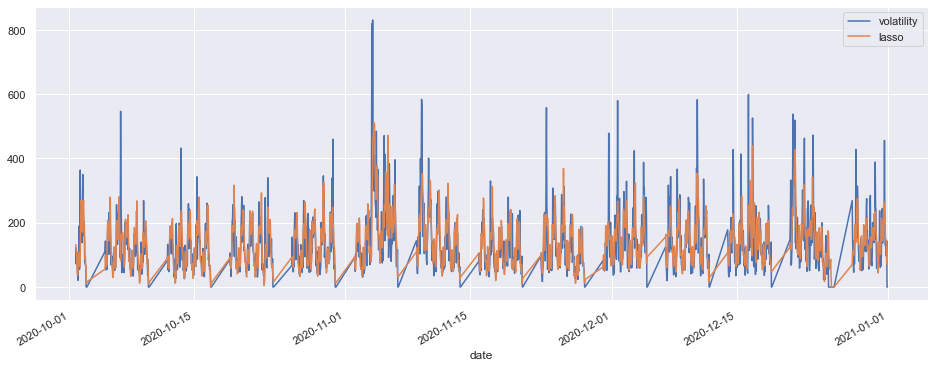

In [116]:
compars[['volatility', 'lasso']].plot(figsize=(16,6))

В целом видно, что модель идет в правильном направлении, прогнозирует спады в конце недели, рост в середине. Можно при необходимости продолжать ее совершенствовать

## Выводы

* Получены данные длф формирования датасета: котировки и новостные данные
* Произведен анализ влияние факторов на волатильность
* Проверено влияние новостей на волатильность рынка - новости отсортированы в зависимости от эффекта. В частности, обнаружены medium новости, которые обладают большим эффектом, чем некотрые high. Например, Labor Force Participation Rate
* Отобран топ новостных показателей, влияющих на волатильность рынка. Выдвинута гипотеза, что топ-20 новостей дает эффект на волатильность более 20% от дневной волатильности всего за 15 минутный интервал выхода показателя. Показана статистическая значимость.
* Построены и сравнены модели линейной регрессии для прогнозирования волатильности с применением в том числе новостных показателей. Наилучший результат показала модель c L1-регуляризацией Lasso с alpha = 0.2. Прогноз модели наложен на фактические значения - продемонстрировано, что модель в целом отрабатывает верно, прогнозируя рост цикличность и сезонность.